<a href="https://colab.research.google.com/github/2yeeji/IMEN415/blob/main/%5B%EB%8B%A4%EB%B3%80%EB%9F%89%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%5D%5B%EA%B3%BC%EC%A0%9C4%5D%5B2021150456%5D%5B%EC%9D%B4%EC%98%88%EC%A7%80%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/다변량분석/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/다변량분석


#사전 작업 사항

In [ ]:
import pandas as pd

earthquake = pd.read_csv("Earthquake_Damage.csv")

In [ ]:
earthquake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [ ]:
nominal_columns = [
    'land_surface_condition', 'foundation_type', 'roof_type',
    'ground_floor_type', 'other_floor_type', 'position',
    'plan_configuration', 'legal_ownership_status'
]

earthquake_encoded = pd.get_dummies(earthquake, columns=nominal_columns)
earthquake_encoded = earthquake_encoded.drop(['building_id'], axis=1)

print(earthquake_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 69 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   geo_level_1_id                          260601 non-null  int64
 1   geo_level_2_id                          260601 non-null  int64
 2   geo_level_3_id                          260601 non-null  int64
 3   count_floors_pre_eq                     260601 non-null  int64
 4   age                                     260601 non-null  int64
 5   area_percentage                         260601 non-null  int64
 6   height_percentage                       260601 non-null  int64
 7   has_superstructure_adobe_mud            260601 non-null  int64
 8   has_superstructure_mud_mortar_stone     260601 non-null  int64
 9   has_superstructure_stone_flag           260601 non-null  int64
 10  has_superstructure_cement_mortar_stone  260601 non-null  int64
 11  

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

sampled_df = earthquake_encoded.groupby('damage_grade', group_keys=False).apply(lambda x: x.sample(int(np.rint(10000 * len(x) / len(earthquake_encoded))), random_state=12345))

y = sampled_df['damage_grade']
X = sampled_df.drop(['damage_grade'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_trn_data, X_temp_data, y_trn_data, y_temp_data = train_test_split(X_scaled, y, train_size=0.6, random_state=12345, stratify=y)
X_val_data, X_test_data, y_val_data, y_test_data = train_test_split(X_temp_data, y_temp_data, test_size=0.5, random_state=12345, stratify=y_temp_data)

In [ ]:
print(X_trn_data.shape)
print(X_val_data.shape)
print(X_test_data.shape)
print(y_trn_data.shape)
print(y_val_data.shape)
print(y_test_data.shape)

(6000, 68)
(2000, 68)
(2000, 68)
(6000,)
(2000,)
(2000,)


In [ ]:
print(earthquake['damage_grade'].value_counts()/len(earthquake['damage_grade']))
print(y.value_counts()/len(y))
print(y_trn_data.value_counts()/len(y_trn_data))
print(y_val_data.value_counts()/len(y_val_data))
print(y_test_data.value_counts()/len(y_test_data))

damage_grade
2    0.568912
3    0.334680
1    0.096408
Name: count, dtype: float64
damage_grade
2    0.5689
3    0.3347
1    0.0964
Name: count, dtype: float64
damage_grade
2    0.568833
3    0.334667
1    0.096500
Name: count, dtype: float64
damage_grade
2    0.569
3    0.335
1    0.096
Name: count, dtype: float64
damage_grade
2    0.5690
3    0.3345
1    0.0965
Name: count, dtype: float64


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

# Performance Evaluation Function ------------------------------------------------
def perf_eval(model, y_test, X_test):

    cm = confusion_matrix(y_test, model.predict(X_test))

    # Simple Accuracy
    ACC = (cm[0,0]+cm[1,1]+cm[2,2])/(cm[0,0]+cm[0,1]+cm[0,2]+cm[1,0]+cm[1,1]+cm[1,2]+cm[2,0]+cm[2,1]+cm[2,2])
    # Balanced Correction Rate
    BCR = np.cbrt((cm[0,0]/(cm[0,0]+cm[0,1]+cm[0,2]))*(cm[1,1]/(cm[1,0]+cm[1,1]+cm[1,2]))*(cm[2,2]/(cm[2,0]+cm[2,1]+cm[2,2])))

    return ACC, BCR

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

# Performance Evaluation Function ------------------------------------------------
def perf_eval2(model, y_test, X_test):

    cm = confusion_matrix(y_test, model.predict(X_test))

    print(cm)

    # Simple Accuracy
    ACC = (cm[0,0]+cm[1,1]+cm[2,2])/(cm[0,0]+cm[0,1]+cm[0,2]+cm[1,0]+cm[1,1]+cm[1,2]+cm[2,0]+cm[2,1]+cm[2,2])
    # Balanced Correction Rate
    BCR = np.cbrt((cm[0,0]/(cm[0,0]+cm[0,1]+cm[0,2]))*(cm[1,1]/(cm[1,0]+cm[1,1]+cm[1,2]))*(cm[2,2]/(cm[2,0]+cm[2,1]+cm[2,2])))

    return round(ACC,3), round(BCR,3)

#Q1

In [ ]:
from sklearn.linear_model import LogisticRegression

ml_logit = LogisticRegression(multi_class='multinomial', solver='newton-cg')
ml_logit.fit(X_trn_data, y_trn_data)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(random_state=12345)
clf = clf.fit(X_trn_data, y_trn_data)

print(clf.get_depth())
print(clf.get_n_leaves())

34
1714


In [ ]:
from sklearn.model_selection import ParameterGrid

criterion = ["gini", "entropy"]
max_depth = [10, 15, 20, None]
min_samples_leaf = [5, 10, 20, 30, 50]

param_grid = {
    'criterion': criterion,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

best_BCR = 0
CART = None

for params in ParameterGrid(param_grid):
    model = DecisionTreeClassifier(**params, random_state=12345)
    model.fit(X_trn_data, y_trn_data)
    ACC, BCR = perf_eval(model, y_val_data, X_val_data)

    if BCR > best_BCR:
        best_BCR = BCR
        CART = model

print("Best Hyperparameter: ", CART.get_params())
print(CART.get_depth())
print(CART.get_n_leaves())

Best Hyperparameter:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}
15
382


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = [(10,), (30,), (50,), (100, ), (10,10), (30,30), (50,50), (100, 100)]
activation = ['logistic', 'tanh', 'relu']
learning_rate_init = [0.001, 0.01, 0.1]
max_iter = [500]
early_stopping = [True]

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation,
    'learning_rate_init': learning_rate_init,
    'max_iter': max_iter,
    'early_stopping': early_stopping
}

best_BCR = 0
ANN = None

for params in ParameterGrid(param_grid):
    model = MLPClassifier(**params, random_state=12345)
    model.fit(X_trn_data, y_trn_data)
    ACC, BCR = perf_eval(model, y_val_data, X_val_data)

    if BCR > best_BCR:
        best_BCR = BCR
        ANN = model

print("Best Hyperparameter: ", ANN.get_params())

Best Hyperparameter:  {'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 12345, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [ ]:
# Performance table
Perf_Table = pd.DataFrame(index=["MLR", "CART", "ANN", "CART Bagging", "RF", "ANN Bagging", "AdaBoost", "GBM"],
                          columns = ["Accuracy", "BCR"])

In [ ]:
Perf_Table.iloc[0] = perf_eval2(ml_logit, y_test_data, X_test_data)
Perf_Table.iloc[1] = perf_eval2(CART, y_test_data, X_test_data)
Perf_Table.iloc[2] = perf_eval2(ANN, y_test_data, X_test_data)
Perf_Table

[[ 53 131   9]
 [ 38 968 132]
 [  5 517 147]]
[[ 76 105  12]
 [ 96 799 243]
 [ 12 311 346]]
[[ 78  92  23]
 [ 74 744 320]
 [ 12 300 357]]


,Accuracy,BCR
MLR,0.584,0.372
CART,0.61,0.523
ANN,0.59,0.52
CART Bagging,NaN,NaN
RF,NaN,NaN
ANN Bagging,NaN,NaN
AdaBoost,NaN,NaN
GBM,NaN,NaN


#Q2

In [ ]:
from sklearn.ensemble import BaggingClassifier

estimators = [10, 30, 50, 100, 200, 300]
best_BCR = 0
best_bagging_cart = None
ACC_bagging_cart = []
BCR_bagging_cart = []

for estimator in estimators:
    bagging_cart_model = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10, random_state=12345),
        n_estimators = estimator,
        n_jobs = -1,
        bootstrap = True,
        verbose = 1,
        random_state=12345
    ).fit(X=X_trn_data, y=y_trn_data)
    ACC, BCR = perf_eval(bagging_cart_model, y_val_data, X_val_data)
    ACC_bagging_cart.append(ACC)
    BCR_bagging_cart.append(BCR)

    print(f'# of bootstrap: {estimator}, ACC: {ACC}, BCR: {BCR}')

    if BCR > best_BCR:
        best_BCR = BCR
        best_bagging_cart = bagging_cart_model

print("Best Hyperparameter: ", best_bagging_cart.get_params())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


# of bootstrap: 10, ACC: 0.66, BCR: 0.5052194809043671


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


# of bootstrap: 30, ACC: 0.674, BCR: 0.5352495596728192


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


# of bootstrap: 50, ACC: 0.678, BCR: 0.5293091996510925


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 100, ACC: 0.6815, BCR: 0.5340334533173472


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 200, ACC: 0.6755, BCR: 0.5232052179274445


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 300, ACC: 0.682, BCR: 0.5293756231428207
Best Hyperparameter:  {'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 15, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples_leaf': 10, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': 12345, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10,
                       random_state=12345), 'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 30, 'n_jobs': -1, 'oob_score': False, 'random_state': 12345, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished


In [ ]:
Perf_Table.iloc[3] = perf_eval2(best_bagging_cart, y_test_data, X_test_data)
Perf_Table

[[ 68 125   0]
 [ 43 952 143]
 [  4 330 335]]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


,Accuracy,BCR
MLR,0.584,0.372
CART,0.61,0.523
ANN,0.59,0.52
CART Bagging,0.678,0.528
RF,NaN,NaN
ANN Bagging,NaN,NaN
AdaBoost,NaN,NaN
GBM,NaN,NaN


#Q3

In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimators = [10, 30, 50, 100, 200, 300]
best_BCR = 0
best_rf_model = None
ACC_rf_model = []
BCR_rf_model = []

for estimator in estimators:
    rf_model = RandomForestClassifier(
        criterion='entropy',
        max_depth=15,
        min_samples_leaf=10,
        random_state=12345,
        n_estimators = estimator,
        verbose = 1
    ).fit(X=X_trn_data, y=y_trn_data)
    var_imp = rf_model.feature_importances_
    var_imp_dict = dict(zip(X.columns, var_imp))
    ACC, BCR = perf_eval(rf_model, y_val_data, X_val_data)
    ACC_rf_model.append(ACC)
    BCR_rf_model.append(BCR)

    print(f'# of bootstrap: {estimator}, ACC: {ACC}, BCR: {BCR}')
    print(f'important featuers: {var_imp_dict}')

    if BCR > best_BCR:
        best_BCR = BCR
        best_rf_model = rf_model

print("Best Hyperparameter: ", best_rf_model.get_params())

# of bootstrap: 10, ACC: 0.6175, BCR: 0.3863185716151305
important featuers: {'geo_level_1_id': 0.16568933294980379, 'geo_level_2_id': 0.06042379269315833, 'geo_level_3_id': 0.05798468271623403, 'count_floors_pre_eq': 0.02630063924965178, 'age': 0.078774459853489, 'area_percentage': 0.047689477956111836, 'height_percentage': 0.030228184539887595, 'has_superstructure_adobe_mud': 0.005681139440954139, 'has_superstructure_mud_mortar_stone': 0.07686536988296747, 'has_superstructure_stone_flag': 0.0012745548649472757, 'has_superstructure_cement_mortar_stone': 0.0006116435186317544, 'has_superstructure_mud_mortar_brick': 0.008964902359248114, 'has_superstructure_cement_mortar_brick': 0.027042555908407366, 'has_superstructure_timber': 0.011206986292097576, 'has_superstructure_bamboo': 0.006171676004868466, 'has_superstructure_rc_non_engineered': 0.003750857619910435, 'has_superstructure_rc_engineered': 0.008673641301613891, 'has_superstructure_other': 0.0005565916712660123, 'count_families': 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


# of bootstrap: 50, ACC: 0.6385, BCR: 0.3790984312071045
important featuers: {'geo_level_1_id': 0.15350301552154103, 'geo_level_2_id': 0.06707377200900833, 'geo_level_3_id': 0.05722947506042071, 'count_floors_pre_eq': 0.030254074466321824, 'age': 0.05884199128552555, 'area_percentage': 0.044625477556848606, 'height_percentage': 0.02971562451896033, 'has_superstructure_adobe_mud': 0.009881634384023275, 'has_superstructure_mud_mortar_stone': 0.06827237411460195, 'has_superstructure_stone_flag': 0.0040360588238427895, 'has_superstructure_cement_mortar_stone': 0.0018923228466725447, 'has_superstructure_mud_mortar_brick': 0.005489365971501039, 'has_superstructure_cement_mortar_brick': 0.04418642305489609, 'has_superstructure_timber': 0.013200256910420333, 'has_superstructure_bamboo': 0.00774058938547436, 'has_superstructure_rc_non_engineered': 0.006083600232347298, 'has_superstructure_rc_engineered': 0.005910810359367704, 'has_superstructure_other': 0.0004021016304000419, 'count_families': 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


# of bootstrap: 100, ACC: 0.6375, BCR: 0.3765224157493253
important featuers: {'geo_level_1_id': 0.1573364023685888, 'geo_level_2_id': 0.06265970701916238, 'geo_level_3_id': 0.05833628217360842, 'count_floors_pre_eq': 0.03268374038854924, 'age': 0.05592342563346368, 'area_percentage': 0.044609194282504545, 'height_percentage': 0.0295720723888482, 'has_superstructure_adobe_mud': 0.00969642785533406, 'has_superstructure_mud_mortar_stone': 0.06615141595868584, 'has_superstructure_stone_flag': 0.003693434520781643, 'has_superstructure_cement_mortar_stone': 0.0017533383288746006, 'has_superstructure_mud_mortar_brick': 0.006605965482363589, 'has_superstructure_cement_mortar_brick': 0.04622110435652558, 'has_superstructure_timber': 0.013545019917141117, 'has_superstructure_bamboo': 0.007424333404630303, 'has_superstructure_rc_non_engineered': 0.006585116560711991, 'has_superstructure_rc_engineered': 0.006716219675523362, 'has_superstructure_other': 0.00023862090230392249, 'count_families': 0.

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


# of bootstrap: 200, ACC: 0.6345, BCR: 0.3780335189328565
important featuers: {'geo_level_1_id': 0.15983535992702982, 'geo_level_2_id': 0.0645929471020367, 'geo_level_3_id': 0.05814827531992026, 'count_floors_pre_eq': 0.03173414037082298, 'age': 0.0581653579987349, 'area_percentage': 0.046299636214222506, 'height_percentage': 0.030194947529377222, 'has_superstructure_adobe_mud': 0.010689263314126453, 'has_superstructure_mud_mortar_stone': 0.06496402767205747, 'has_superstructure_stone_flag': 0.003232627944416305, 'has_superstructure_cement_mortar_stone': 0.0019788849728404304, 'has_superstructure_mud_mortar_brick': 0.006581271495769368, 'has_superstructure_cement_mortar_brick': 0.042770842878850884, 'has_superstructure_timber': 0.01370903554295277, 'has_superstructure_bamboo': 0.008131458895998747, 'has_superstructure_rc_non_engineered': 0.005461755779389355, 'has_superstructure_rc_engineered': 0.005268067119977781, 'has_superstructure_other': 0.00024177012859450512, 'count_families': 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.9s


# of bootstrap: 300, ACC: 0.6315, BCR: 0.37388867352744903
important featuers: {'geo_level_1_id': 0.15497121008060222, 'geo_level_2_id': 0.06427102523827043, 'geo_level_3_id': 0.05748368366795331, 'count_floors_pre_eq': 0.03148186487185251, 'age': 0.05830361082583326, 'area_percentage': 0.04661351542410774, 'height_percentage': 0.030056295065696816, 'has_superstructure_adobe_mud': 0.009957054105441097, 'has_superstructure_mud_mortar_stone': 0.07020242521664084, 'has_superstructure_stone_flag': 0.0032072980741084654, 'has_superstructure_cement_mortar_stone': 0.0019026658610399804, 'has_superstructure_mud_mortar_brick': 0.006898273017621031, 'has_superstructure_cement_mortar_brick': 0.040874357515722326, 'has_superstructure_timber': 0.014032141526357312, 'has_superstructure_bamboo': 0.007818257676507021, 'has_superstructure_rc_non_engineered': 0.0051046521955274244, 'has_superstructure_rc_engineered': 0.003912522327473765, 'has_superstructure_other': 0.00025264405462810564, 'count_famili

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s


In [ ]:
Perf_Table.iloc[4] = perf_eval2(best_rf_model, y_test_data, X_test_data)
Perf_Table

[[  47  142    4]
 [  35 1008   95]
 [   4  468  197]]


,Accuracy,BCR
MLR,0.584,0.372
CART,0.61,0.523
ANN,0.59,0.52
CART Bagging,0.678,0.528
RF,0.626,0.399
ANN Bagging,NaN,NaN
AdaBoost,NaN,NaN
GBM,NaN,NaN


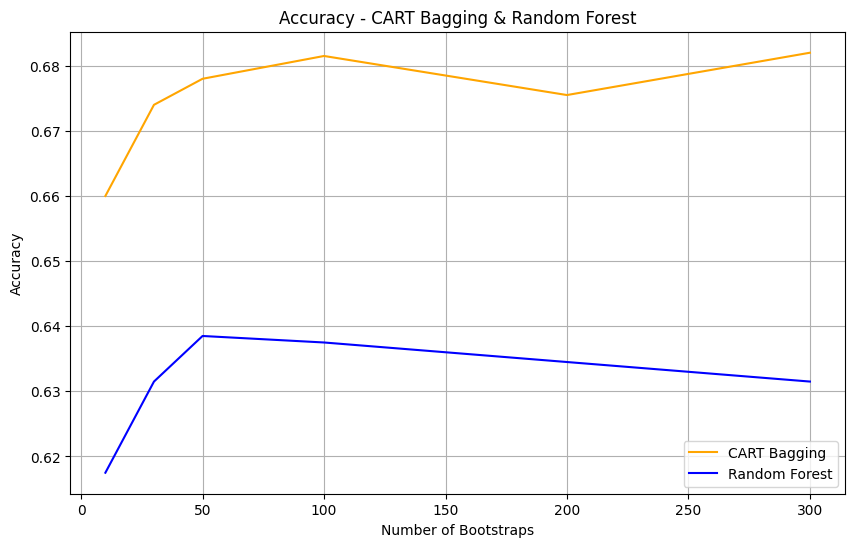

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(estimators, ACC_bagging_cart, color='orange', label='CART Bagging')
plt.plot(estimators, ACC_rf_model, color='blue', label='Random Forest')

plt.title('Accuracy - CART Bagging & Random Forest')
plt.xlabel('Number of Bootstraps')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

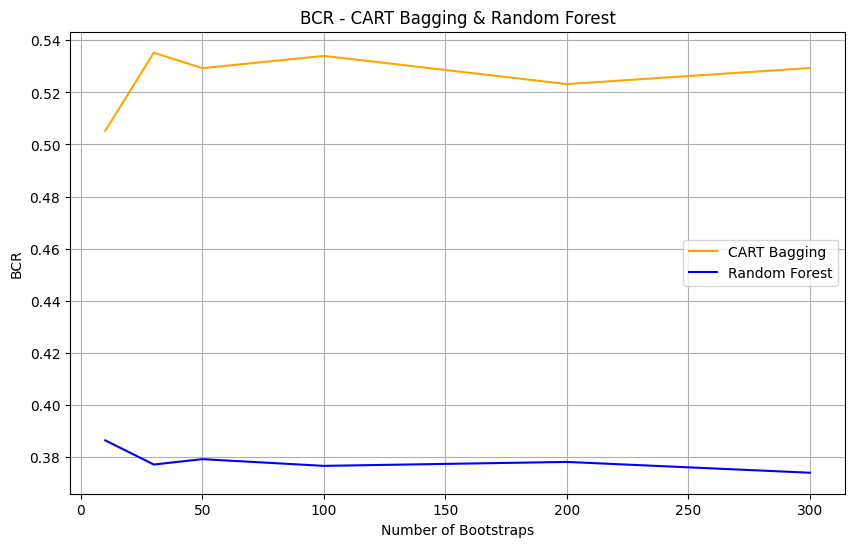

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(estimators, BCR_bagging_cart, color='orange', label='CART Bagging')
plt.plot(estimators, BCR_rf_model, color='blue', label='Random Forest')

plt.title('BCR - CART Bagging & Random Forest')
plt.xlabel('Number of Bootstraps')
plt.ylabel('BCR')
plt.legend()

plt.grid(True)
plt.show()

#Q4

In [ ]:
ACC_ANN = []
BCR_ANN = []

for i in range(10):

    X_trn_data2, X_temp_data2, y_trn_data2, y_temp_data2 = train_test_split(X_scaled, y, train_size=0.6, stratify=y)
    X_val_data2, X_test_data2, y_val_data2, y_test_data2 = train_test_split(X_temp_data2, y_temp_data2, test_size=0.5, stratify=y_temp_data2)

    model = MLPClassifier(hidden_layer_sizes=(100,),
                          activation='logistic',
                          learning_rate_init=0.01,
                          max_iter=500,
                          early_stopping=True,
                          random_state=12345)
    model.fit(X_trn_data2, y_trn_data2)
    ACC, BCR = perf_eval(model, y_test_data2, X_test_data2)
    ACC_ANN.append(ACC)
    BCR_ANN.append(BCR)

In [ ]:
import statistics

print(f'Mean of ACC_ANN: {statistics.mean(ACC_ANN)}')
print(f'SD of ACC_ANN: {statistics.stdev(ACC_ANN)}')
print(f'Mean of BCR_ANN: {statistics.mean(BCR_ANN)}')
print(f'SD of BCR_ANN: {statistics.stdev(BCR_ANN)}')

Mean of ACC_ANN: 0.6012500000000001
SD of ACC_ANN: 0.009970094170958357
Mean of BCR_ANN: 0.4428593035924758
SD of BCR_ANN: 0.05423075544669488


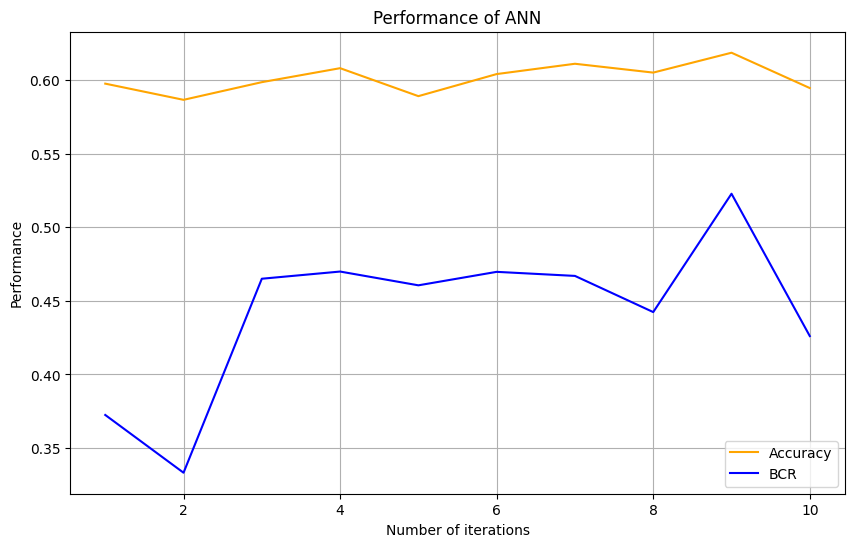

In [ ]:
import matplotlib.pyplot as plt

index = [i for i in range(1,11)]

plt.figure(figsize=(10, 6))
plt.plot(index, ACC_ANN, color='orange', label='Accuracy')
plt.plot(index, BCR_ANN, color='blue', label='BCR')

plt.title('Performance of ANN')
plt.xlabel('Number of iterations')
plt.ylabel('Performance')
plt.legend()

plt.grid(True)
plt.show()

#Q5

In [ ]:
from sklearn.ensemble import BaggingClassifier

estimators = [10, 30, 50, 100, 200, 300]
best_BCR = 0
best_bagging_ann = None

for estimator in estimators:
    bagging_ann_model = BaggingClassifier(
        base_estimator = MLPClassifier(hidden_layer_sizes=(100,),
                          activation='logistic',
                          learning_rate_init=0.01,
                          max_iter=500,
                          early_stopping=True,
                          random_state=12345
                          ),
        n_estimators = estimator,
        n_jobs = -1,
        bootstrap = True,
        verbose = 1,
        random_state=12345
    ).fit(X=X_trn_data, y=y_trn_data)

    ACC, BCR = perf_eval(bagging_ann_model, y_val_data, X_val_data)

    print(f'# of bootstrap: {estimator}, ACC: {ACC}, BCR: {BCR}')

    if BCR > best_BCR:
        best_BCR = BCR
        best_bagging_ann = bagging_ann_model

print("Best Hyperparameter: ", best_bagging_ann.get_params())

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   26.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


# of bootstrap: 10, ACC: 0.6065, BCR: 0.46765994800734995


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 30, ACC: 0.6175, BCR: 0.47262793519467505


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 50, ACC: 0.6175, BCR: 0.476141882682426


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  4.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 100, ACC: 0.6175, BCR: 0.47095123467785144


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  9.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 200, ACC: 0.615, BCR: 0.473586671816976


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 13.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


# of bootstrap: 300, ACC: 0.62, BCR: 0.47719432935901435
Best Hyperparameter:  {'base_estimator__activation': 'logistic', 'base_estimator__alpha': 0.0001, 'base_estimator__batch_size': 'auto', 'base_estimator__beta_1': 0.9, 'base_estimator__beta_2': 0.999, 'base_estimator__early_stopping': True, 'base_estimator__epsilon': 1e-08, 'base_estimator__hidden_layer_sizes': (100,), 'base_estimator__learning_rate': 'constant', 'base_estimator__learning_rate_init': 0.01, 'base_estimator__max_fun': 15000, 'base_estimator__max_iter': 500, 'base_estimator__momentum': 0.9, 'base_estimator__n_iter_no_change': 10, 'base_estimator__nesterovs_momentum': True, 'base_estimator__power_t': 0.5, 'base_estimator__random_state': 12345, 'base_estimator__shuffle': True, 'base_estimator__solver': 'adam', 'base_estimator__tol': 0.0001, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': False, 'base_estimator__warm_start': False, 'base_estimator': MLPClassifier(activation='logistic', early_stopp

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.8s finished


In [ ]:
Perf_Table.iloc[5] = perf_eval2(best_bagging_ann, y_test_data, X_test_data)
Perf_Table

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[[ 57 120  16]
 [ 51 858 229]
 [  7 382 280]]


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.4s finished


,Accuracy,BCR
MLR,0.584,0.372
CART,0.61,0.523
ANN,0.59,0.52
CART Bagging,0.678,0.528
RF,0.626,0.399
ANN Bagging,0.598,0.453
AdaBoost,NaN,NaN
GBM,NaN,NaN


#Q6

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import AdaBoostClassifier

n_estimators = [10, 30, 50, 100, 200, 300]
learning_rate = [0.01, 0.1, 1, 10, 100]

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate
}

best_BCR = 0
best_adaboost = None

for params in ParameterGrid(param_grid):
    adaboost_model = AdaBoostClassifier(**params,
                                        base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=10, random_state=12345),
                                        random_state=12345)
    adaboost_model.fit(X_trn_data, y_trn_data)

    ACC, BCR = perf_eval(adaboost_model, y_val_data, X_val_data)

    print(f'{params}, ACC: {ACC}, BCR: {BCR}')

    if BCR > best_BCR:
        best_BCR = BCR
        best_adaboost = adaboost_model

print("Best Hyperparameter: ", best_adaboost.get_params())

{'learning_rate': 0.01, 'n_estimators': 10}, ACC: 0.651, BCR: 0.5197617560498574
{'learning_rate': 0.01, 'n_estimators': 30}, ACC: 0.6665, BCR: 0.510189305311929
{'learning_rate': 0.01, 'n_estimators': 50}, ACC: 0.667, BCR: 0.4636022107298475
{'learning_rate': 0.01, 'n_estimators': 100}, ACC: 0.6645, BCR: 0.41510794537631035
{'learning_rate': 0.01, 'n_estimators': 200}, ACC: 0.6595, BCR: 0.40174908576220425
{'learning_rate': 0.01, 'n_estimators': 300}, ACC: 0.647, BCR: 0.3921447779929139
{'learning_rate': 0.1, 'n_estimators': 10}, ACC: 0.6385, BCR: 0.46579474721759406
{'learning_rate': 0.1, 'n_estimators': 30}, ACC: 0.6325, BCR: 0.38084521778278524
{'learning_rate': 0.1, 'n_estimators': 50}, ACC: 0.637, BCR: 0.39836257865163754
{'learning_rate': 0.1, 'n_estimators': 100}, ACC: 0.6455, BCR: 0.3948485702199801
{'learning_rate': 0.1, 'n_estimators': 200}, ACC: 0.645, BCR: 0.37921142644521477
{'learning_rate': 0.1, 'n_estimators': 300}, ACC: 0.6455, BCR: 0.4042456373133391
{'learning_rate'

In [ ]:
Perf_Table.iloc[6] = perf_eval2(best_adaboost, y_test_data, X_test_data)
Perf_Table

[[ 72 116   5]
 [ 82 838 218]
 [  9 316 344]]


,Accuracy,BCR
MLR,0.584,0.372
CART,0.61,0.523
ANN,0.59,0.52
CART Bagging,0.678,0.528
RF,0.626,0.399
ANN Bagging,0.598,0.453
AdaBoost,0.627,0.521
GBM,NaN,NaN


#Q7

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [50, 100, 150]
learning_rate = [0.01, 0.1, 1]
subsample = [0.7, 1.0]
max_depth = [10, 15, 20, None]
min_samples_leaf = [5, 10, 20]

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'subsample': subsample,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf
}

best_BCR = 0
best_gbm_model = None

for params in ParameterGrid(param_grid):
    gbm_model = GradientBoostingClassifier(**params, random_state = 12345)
    gbm_model.fit(X_trn_data, y_trn_data)

    var_imp = gbm_model.feature_importances_
    var_imp_dict_gbm = dict(zip(X.columns, var_imp))
    ACC, BCR = perf_eval(gbm_model, y_val_data, X_val_data)

    print(f'{params}, ACC: {ACC}, BCR: {BCR}')
    print(f'important featuers: {var_imp_dict_gbm}')

    if BCR > best_BCR:
        best_BCR = BCR
        best_gbm_model = gbm_model

print("Best Hyperparameter: ", best_gbm_model.get_params())

{'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50, 'subsample': 0.7}, ACC: 0.644, BCR: 0.14271085937686243
important featuers: {'geo_level_1_id': 0.2688641798531014, 'geo_level_2_id': 0.12470546865660037, 'geo_level_3_id': 0.12927294103928327, 'count_floors_pre_eq': 0.011458092483033075, 'age': 0.06570411339919105, 'area_percentage': 0.06275328945900989, 'height_percentage': 0.03819517385809987, 'has_superstructure_adobe_mud': 0.0043472580317827705, 'has_superstructure_mud_mortar_stone': 0.01871615894148663, 'has_superstructure_stone_flag': 0.002980361890029214, 'has_superstructure_cement_mortar_stone': 0.0008789554593965972, 'has_superstructure_mud_mortar_brick': 0.006829458133128789, 'has_superstructure_cement_mortar_brick': 0.009031881262170218, 'has_superstructure_timber': 0.010313625100801502, 'has_superstructure_bamboo': 0.004165466098645364, 'has_superstructure_rc_non_engineered': 0.003632520392864882, 'has_superstructure_rc_engineered': 0.001450

In [ ]:
Perf_Table.iloc[7] = perf_eval2(best_gbm_model, y_test_data, X_test_data)
Perf_Table

[[ 75 115   3]
 [ 53 888 197]
 [  3 299 367]]


,Accuracy,BCR
MLR,0.584,0.372
CART,0.61,0.523
ANN,0.59,0.52
CART Bagging,0.678,0.528
RF,0.626,0.399
ANN Bagging,0.598,0.453
AdaBoost,0.627,0.521
GBM,0.665,0.55


In [ ]:
var_imp = best_rf_model.feature_importances_

var_imp_df = pd.DataFrame(
    data = var_imp,
    columns = ['variable importance'],
    index = X.columns
).sort_values('variable importance', ascending=False)
var_imp_df

,variable importance
geo_level_1_id,0.165689
foundation_type_r,0.157694
age,0.078774
has_superstructure_mud_mortar_stone,0.076865
geo_level_2_id,0.060424
...,...
ground_floor_type_m,0.000000
has_secondary_use_gov_office,0.000000
has_secondary_use_use_police,0.000000
has_secondary_use_other,0.000000


<Axes: xlabel='variable importance', ylabel='None'>

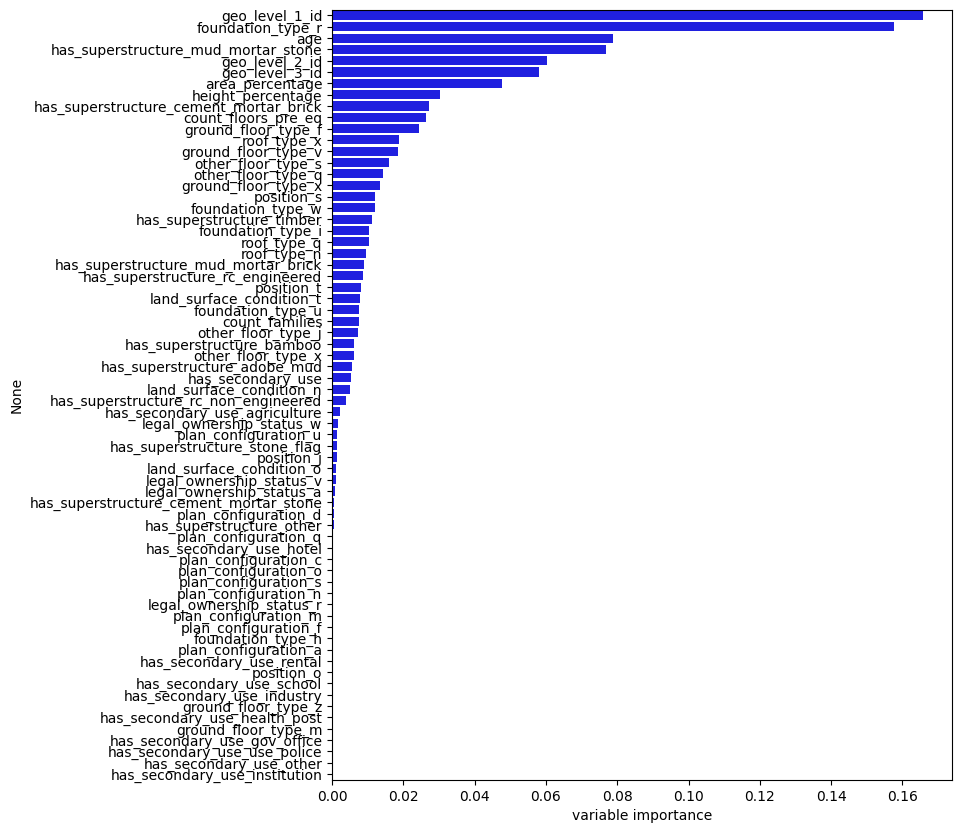

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,10))
sns.barplot(
    x = 'variable importance',
    y = var_imp_df.index,
    color = 'blue',
    data = var_imp_df
)

In [ ]:
var_imp = best_gbm_model.feature_importances_

var_imp_df = pd.DataFrame(
    data = var_imp,
    columns = ['variable importance'],
    index = X.columns
).sort_values('variable importance', ascending=False)
var_imp_df

,variable importance
geo_level_1_id,0.198776
geo_level_3_id,0.194794
geo_level_2_id,0.170907
age,0.076985
foundation_type_r,0.066476
...,...
has_secondary_use_gov_office,0.000000
plan_configuration_c,0.000000
plan_configuration_a,0.000000
has_secondary_use_use_police,0.000000


<Axes: xlabel='variable importance', ylabel='None'>

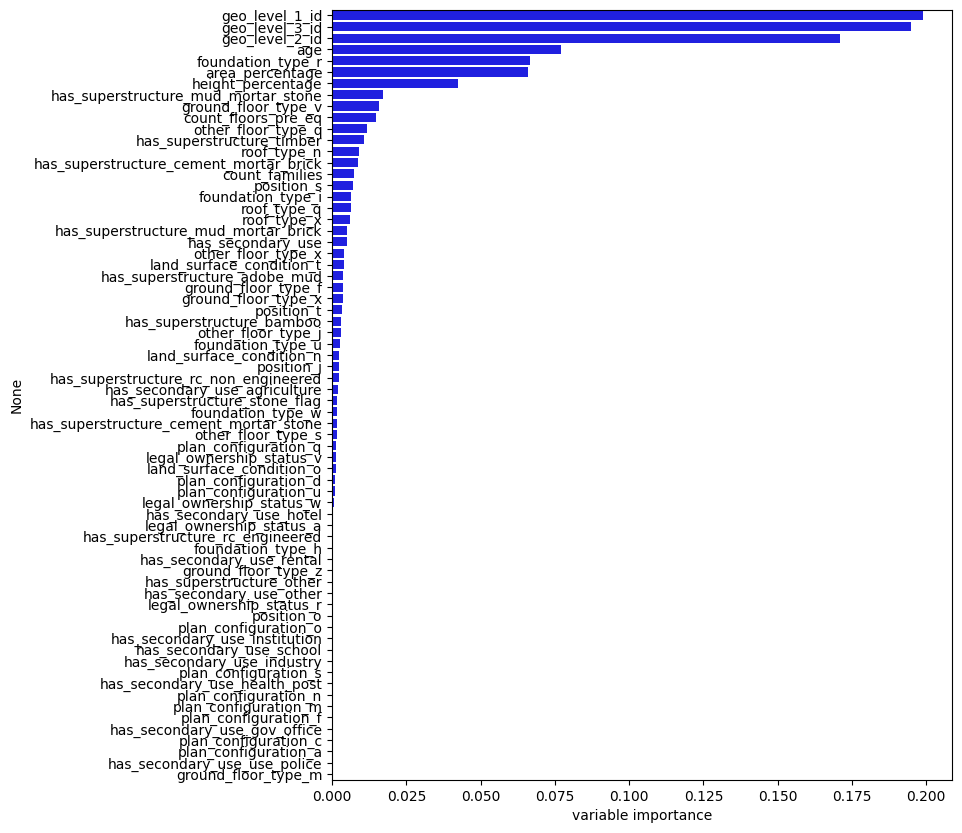

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,10))
sns.barplot(
    x = 'variable importance',
    y = var_imp_df.index,
    color = 'blue',
    data = var_imp_df
)

#Extra Question

##Under sampling

In [ ]:
y.value_counts()

damage_grade
2    5689
3    3347
1     964
Name: count, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

X_undersampled, y_undersampled = RandomUnderSampler(random_state=12345).fit_resample(X_scaled, y)

X_oversampled, y_oversampled = RandomOverSampler(random_state=12345).fit_resample(X_scaled, y)

X_smotesampled, y_smotesampled = SMOTE(random_state=12345).fit_resample(X_scaled, y)

strategy = {1:5689, 2:5689, 3:5689}
X_adasynsampled, y_adasynsampled = ADASYN(sampling_strategy=strategy, random_state=12345).fit_resample(X_scaled, y)

print(y_undersampled.value_counts())
print(y_oversampled.value_counts())
print(y_smotesampled.value_counts())
print(y_adasynsampled.value_counts())

damage_grade
1    964
2    964
3    964
Name: count, dtype: int64
damage_grade
1    5689
2    5689
3    5689
Name: count, dtype: int64
damage_grade
1    5689
2    5689
3    5689
Name: count, dtype: int64
damage_grade
3    6048
2    5689
1    5575
Name: count, dtype: int64


In [ ]:
X_trn_under, X_temp_under, y_trn_under, y_temp_under = train_test_split(X_undersampled, y_undersampled, train_size=0.6, stratify=y_undersampled)
X_val_under, X_test_under, y_val_under, y_test_under = train_test_split(X_temp_under, y_temp_under, test_size=0.5, stratify=y_temp_under)

X_trn_over, X_temp_over, y_trn_over, y_temp_over = train_test_split(X_oversampled, y_oversampled, train_size=0.6, stratify=y_oversampled)
X_val_over, X_test_over, y_val_over, y_test_over = train_test_split(X_temp_over, y_temp_over, test_size=0.5, stratify=y_temp_over)

X_trn_smote, X_temp_smote, y_trn_smote, y_temp_smote = train_test_split(X_smotesampled, y_smotesampled, train_size=0.6, stratify=y_smotesampled)
X_val_smote, X_test_smote, y_val_smote, y_test_smote = train_test_split(X_temp_smote, y_temp_smote, test_size=0.5, stratify=y_temp_smote)

X_trn_adasyn, X_temp_adasyn, y_trn_adasyn, y_temp_adasyn = train_test_split(X_adasynsampled, y_adasynsampled, train_size=0.6, stratify=y_adasynsampled)
X_val_adasyn, X_test_adasyn, y_val_adasyn, y_test_adasyn = train_test_split(X_temp_adasyn, y_temp_adasyn, test_size=0.5, stratify=y_temp_adasyn)

In [ ]:
gbm_undersampling_model = GradientBoostingClassifier(learning_rate=0.1,
                                       max_depth=None,
                                       min_samples_leaf=20,
                                       n_estimators=50,
                                       subsample=1.0,
                                       random_state = 12345)
gbm_undersampling_model.fit(X_trn_under, y_trn_under)

GradientBoostingClassifier(max_depth=None, min_samples_leaf=20, n_estimators=50,
                           random_state=12345)

In [ ]:
gbm_oversampling_model = GradientBoostingClassifier(learning_rate=0.1,
                                       max_depth=None,
                                       min_samples_leaf=20,
                                       n_estimators=50,
                                       subsample=1.0,
                                       random_state = 12345)
gbm_oversampling_model.fit(X_trn_over, y_trn_over)

GradientBoostingClassifier(max_depth=None, min_samples_leaf=20, n_estimators=50,
                           random_state=12345)

In [ ]:
gbm_smotesampling_model = GradientBoostingClassifier(learning_rate=0.1,
                                       max_depth=None,
                                       min_samples_leaf=20,
                                       n_estimators=50,
                                       subsample=1.0,
                                       random_state = 12345)
gbm_smotesampling_model.fit(X_trn_smote, y_trn_smote)

GradientBoostingClassifier(max_depth=None, min_samples_leaf=20, n_estimators=50,
                           random_state=12345)

In [ ]:
gbm_adasynsampling_model = GradientBoostingClassifier(learning_rate=0.1,
                                       max_depth=None,
                                       min_samples_leaf=20,
                                       n_estimators=50,
                                       subsample=1.0,
                                       random_state = 12345)
gbm_adasynsampling_model.fit(X_trn_adasyn, y_trn_adasyn)

GradientBoostingClassifier(max_depth=None, min_samples_leaf=20, n_estimators=50,
                           random_state=12345)

In [ ]:
Perf_Table2 = pd.DataFrame(index=["Undersampling", "Oversampling", "SMOTE", "ADASYN"],
                          columns = ["Accuracy", "BCR"])
Perf_Table2.iloc[0] = perf_eval2(gbm_undersampling_model, y_test_under, X_test_under)
Perf_Table2.iloc[1] = perf_eval2(gbm_oversampling_model, y_test_over, X_test_over)
Perf_Table2.iloc[2] = perf_eval2(gbm_smotesampling_model, y_test_smote, X_test_smote)
Perf_Table2.iloc[3] = perf_eval2(gbm_adasynsampling_model, y_test_adasyn, X_test_adasyn)
Perf_Table2

[[148  34  11]
 [ 40  93  60]
 [ 15  63 115]]
[[1128   10    0]
 [ 138  730  270]
 [  14  185  939]]
[[998  88  52]
 [ 81 827 230]
 [ 37 276 825]]
[[989  71  55]
 [ 74 823 241]
 [ 52 267 891]]


,Accuracy,BCR
Undersampling,0.615,0.604
Oversampling,0.819,0.807
SMOTE,0.776,0.773
ADASYN,0.781,0.779
